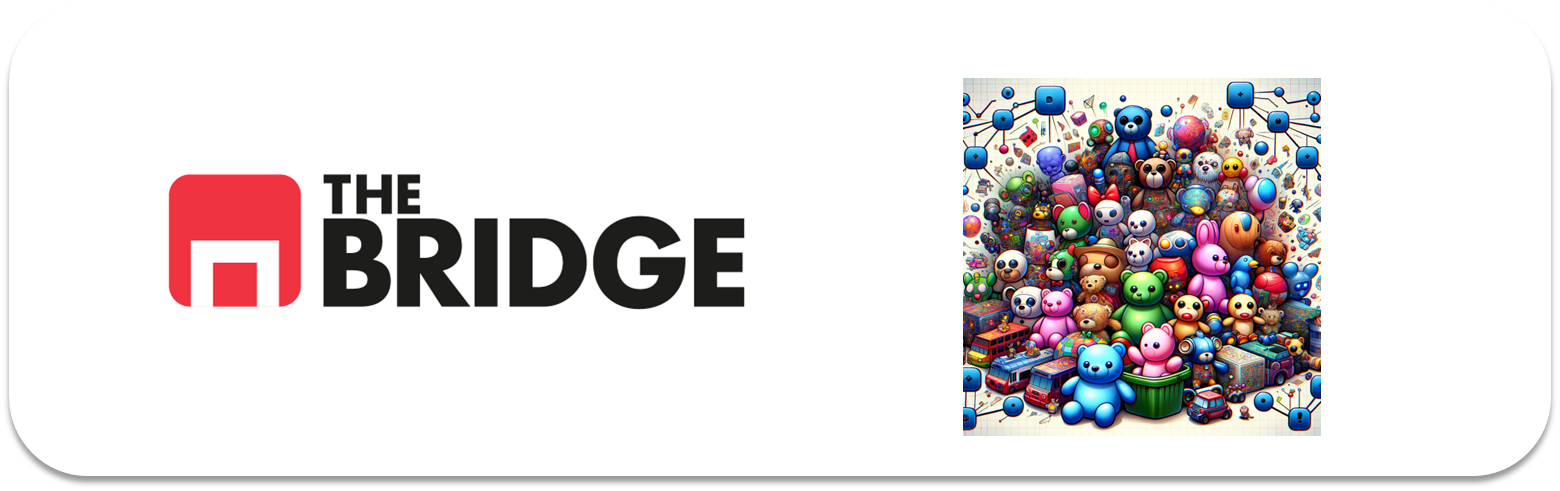

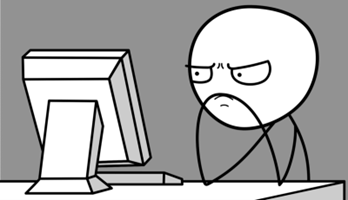

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as shc



### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [2]:
empowering_df = pd.read_csv("/Users/patri/Desktop/DS24/ONLINE_DS_THEBRIDGE_PGF/SPRINT_13/UNIDAD_2/practica_obligatoria/empowering_drinks.csv", sep="|")

empowering_df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [4]:
empowering_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


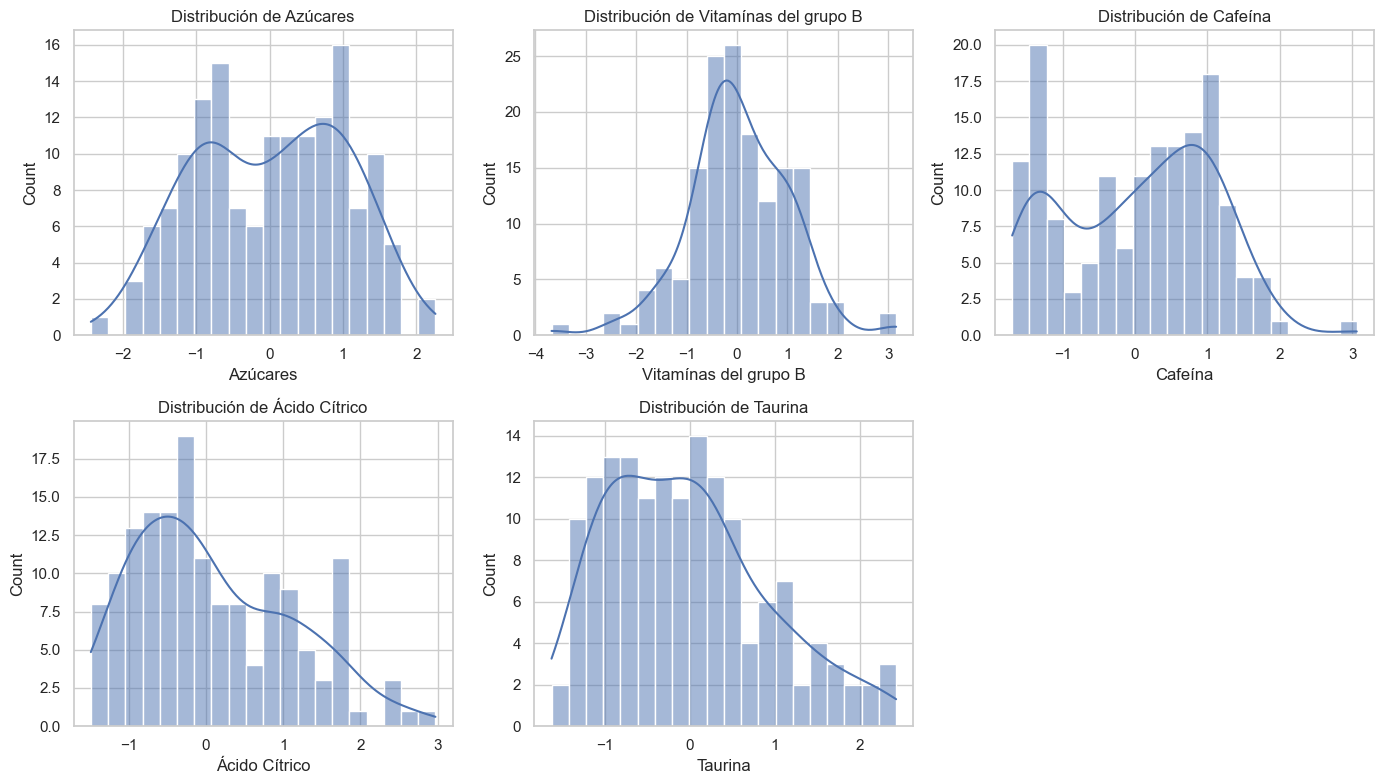

In [5]:
#MINIEDA

sns.set(style="whitegrid")

# Histograma por cada feature
plt.figure(figsize=(14, 8))
for i, column in enumerate(empowering_df.columns):
    plt.subplot(2, 3, i+1)
    sns.histplot(empowering_df[column], kde=True, bins=20)
    plt.title(f"Distribución de {column}")
plt.tight_layout()
plt.show();

- Azúcares y Cafeína están más centradas en torno a la media, con distribuciones bastante suaves.
- Ácido Cítrico tiene una cola hacia valores altos posiblemente algunos valores extremos.
- Taurina tiene una distribución más amplia y algo asimétrica.
- Vitaminas del grupo B parece tener una ligera forma gaussiana



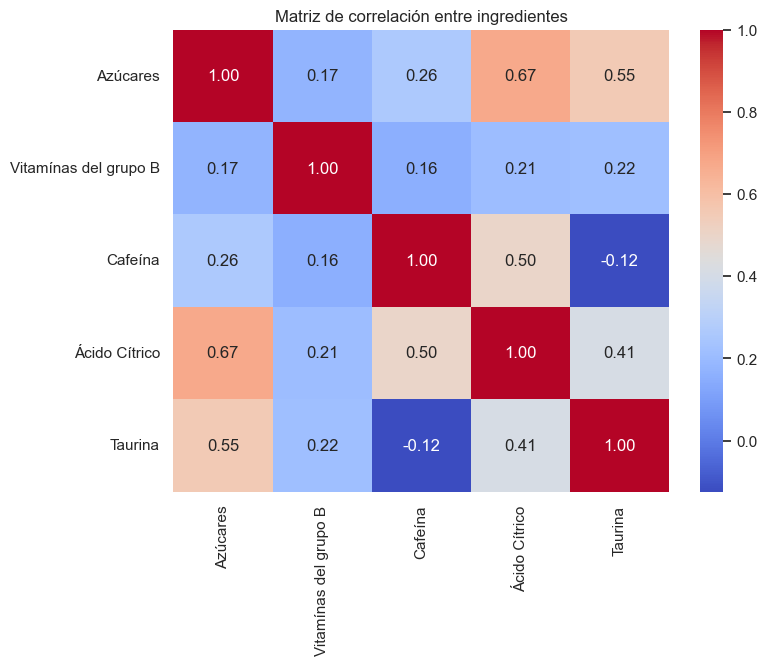

In [6]:
#Matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(empowering_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre ingredientes")
plt.show();



La mayoría de las variables tienen correlaciones moderadas entre sí.
- Azucares y Ácido Cítrico tienen una correlación de 0,67.
- Azúcares y Taurina también 0,55.
- Vitaminas del grupo B está menos correlacionada con las demás

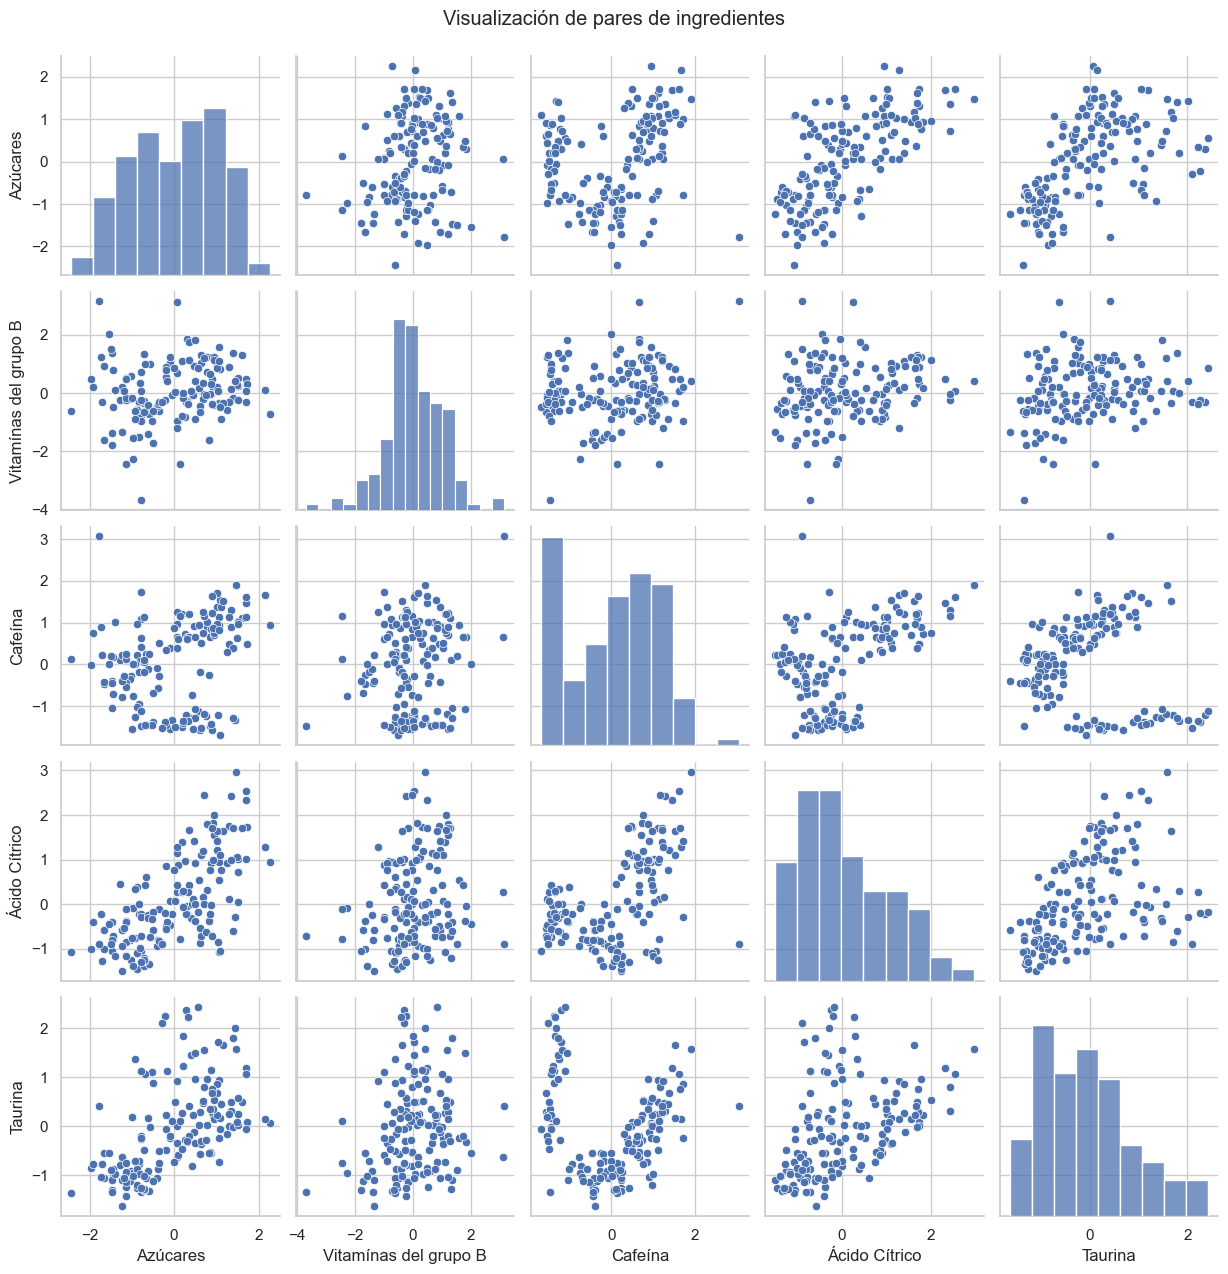

In [7]:
#visualización por pares
sns.pairplot(empowering_df)
plt.suptitle("Visualización de pares de ingredientes", y=1.02)
plt.show()


### selección features

- ["Cafeína", "Ácido Cítrico"] = buena separación visual + correlación moderada.
- ["Vitaminas del grupo B", "Taurina"] = también muestran variación interesante.
- ["Azúcares", "Taurina"] = posible agrupación


Elegimos Cafeina y Ácido Cítrico

In [20]:
#Selección de variables
X = empowering_df[["Cafeína", "Ácido Cítrico"]]

# Normalización 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#dataframe con las features escaladas
X_scaled_df= pd.DataFrame(X_scaled, columns=["Cafeína (esc)", "Ácido Cítrico (esc)"])
X_scaled_df.head()

,Cafeína (esc),Ácido Cítrico (esc)
0,0.957824,0.927289
1,0.667526,0.879813
2,1.132002,1.307094
3,1.373917,2.240782
4,0.599790,-0.117176


In [21]:
# DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Agregamos los clusters al DataFrame
X_scaled_df["Cluster"] = dbscan_labels

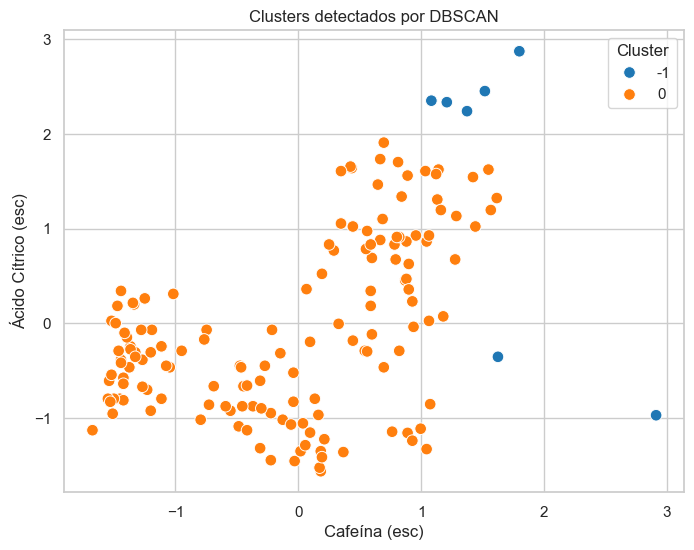

In [22]:
#visualizar los clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_scaled_df, x="Cafeína (esc)", y="Ácido Cítrico (esc)", hue="Cluster", palette="tab10", s=70)
plt.title("Clusters detectados por DBSCAN")
plt.legend(title="Cluster")
plt.show();

eps = 0.5 parece razonable, ya que:
- Agrupa correctamente un gran bloque compacto de puntos.
- Detecta bien algunos valores atípicos que están aislados.

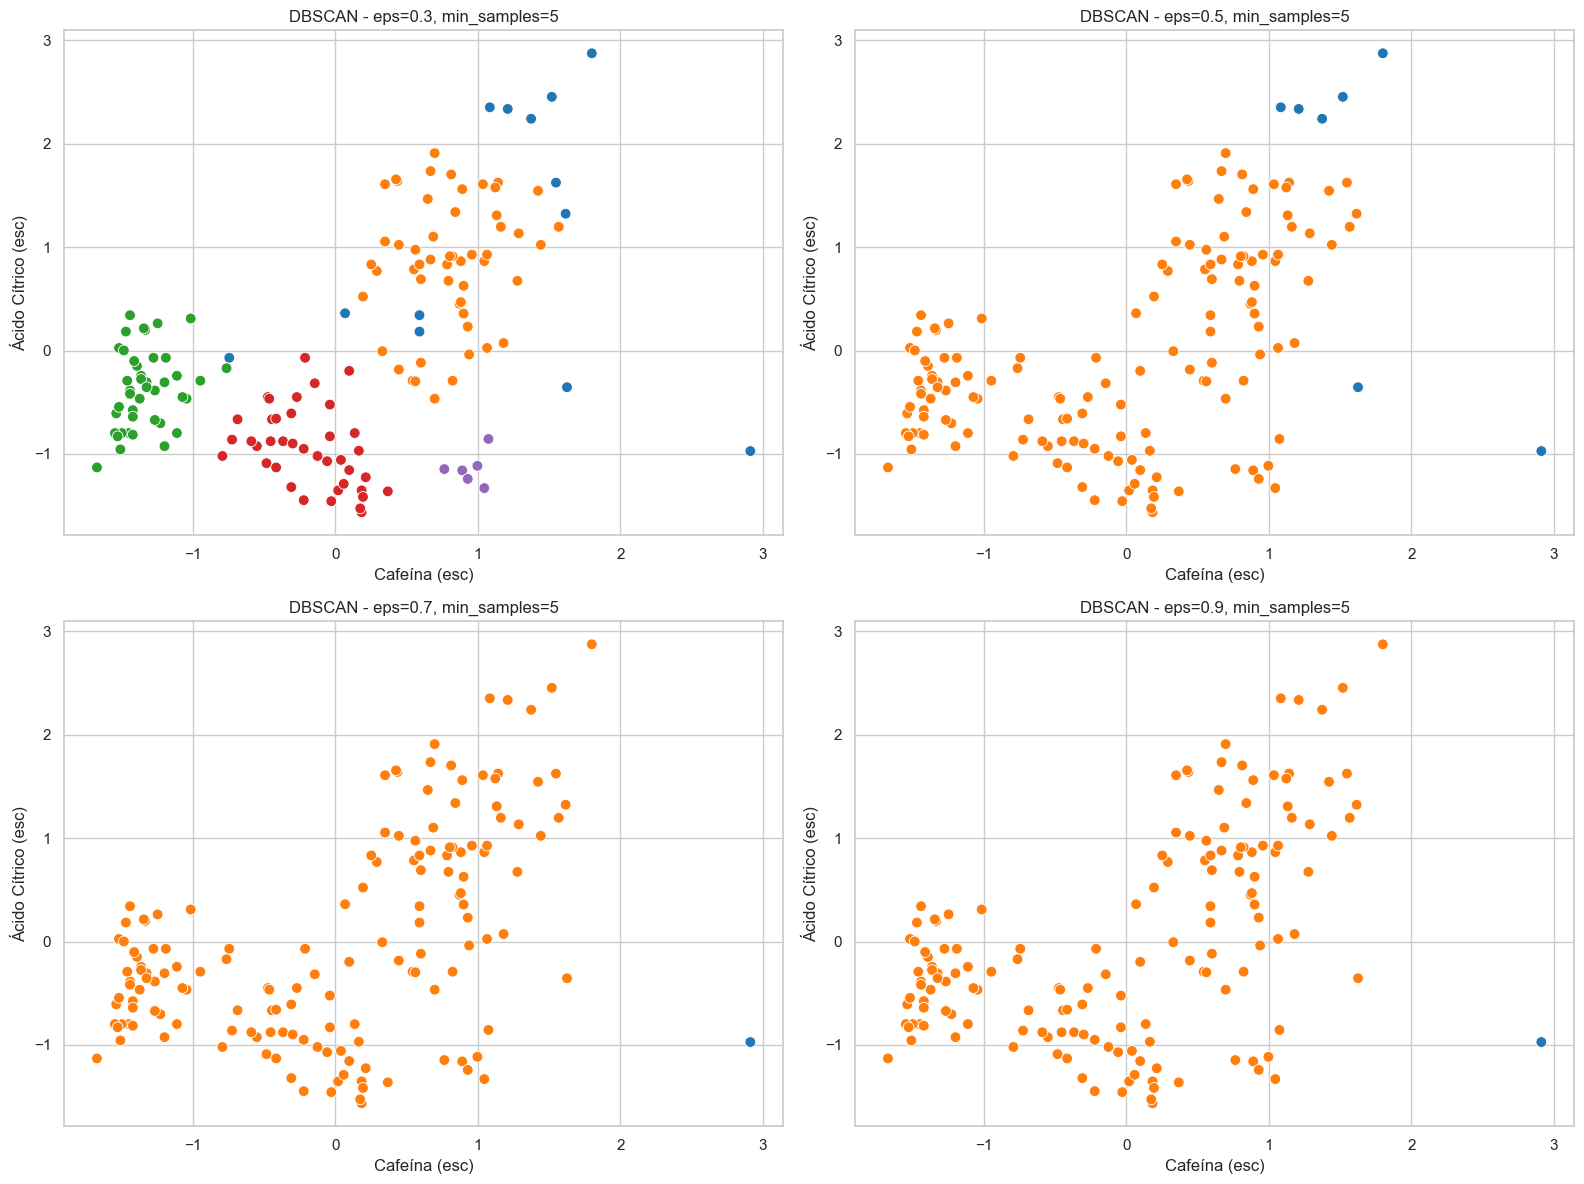

In [23]:
# Probar diferentes valores de eps
eps_values = [0.3, 0.5, 0.7, 0.9]
min_samples = 5

plt.figure(figsize=(16, 12))

for i, eps in enumerate(eps_values, 1):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)

    df_temp = X_scaled_df.copy()
    df_temp["Cluster"] = labels

    plt.subplot(2, 2, i)
    sns.scatterplot(data=df_temp, x="Cafeína (esc)", y="Ácido Cítrico (esc)", hue="Cluster", palette="tab10", s=60, legend=False)
    plt.title(f"DBSCAN - eps={eps}, min_samples={min_samples}")
    plt.xlabel("Cafeína (esc)")
    plt.ylabel("Ácido Cítrico (esc)")

plt.tight_layout()
plt.show();

### eps = 0.3

- Detecta varios clusters pequeños.
- Muchos puntos quedan fuera de los grupos (outliers).

### eps = 0.5

- Detecta 1 cluster dominante + algunos outliers.

### eps = 0.7 y 0.9

- Casi todos los puntos se agrupan en un único cluster.
- Solo 1 o 2 outliers.


In [26]:
# Número de vecinos = min_samples
k = 5
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

k_distances = np.sort(distances[:, k-1])


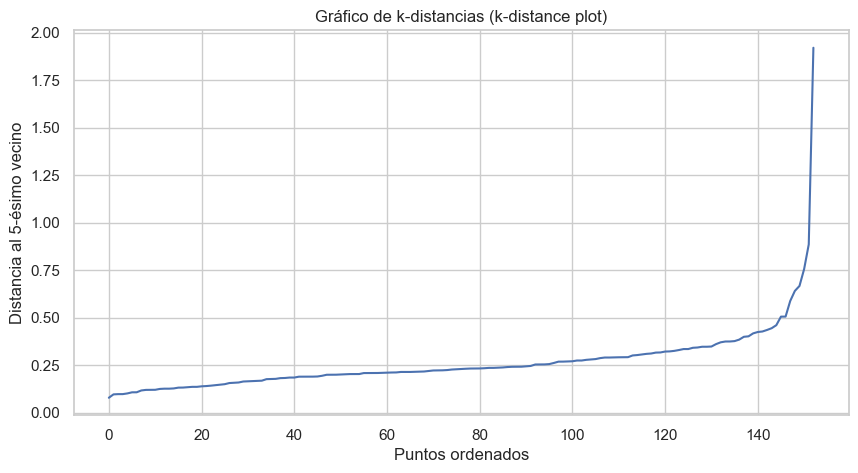

In [27]:
# Gráfico
plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.ylabel(f"Distancia al {k}-ésimo vecino")
plt.xlabel("Puntos ordenados")
plt.title("Gráfico de k-distancias (k-distance plot)")
plt.grid(True)
plt.show();

alrededor de eps ≈ 0.3 - 0.35 empieza a subir más rápido ("codo"), por lo que, eps = 0.3 sería una elección razonable y justificada visualmente para DBSCAN.

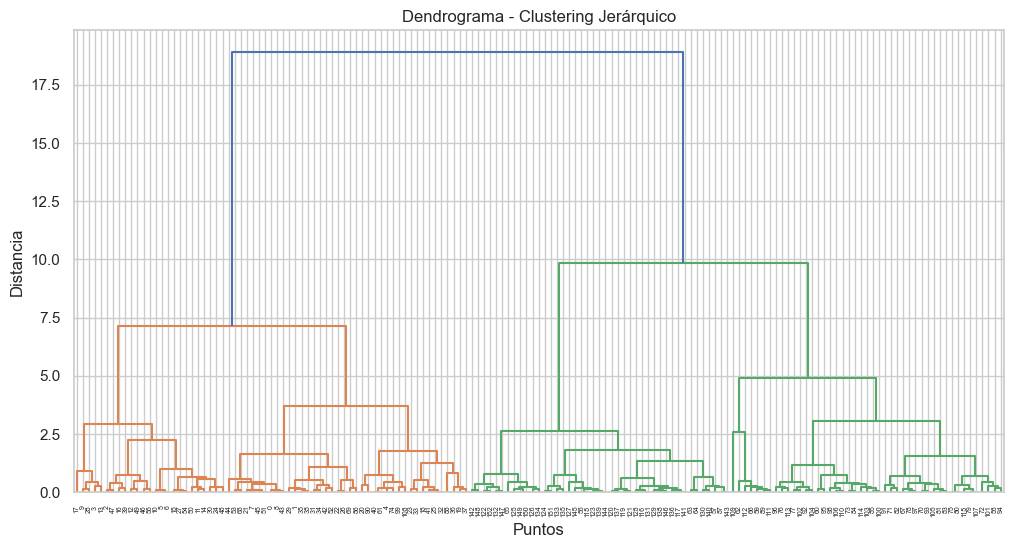

In [30]:
# Crear el dendrograma
plt.figure(figsize=(12, 6))
shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.title("Dendrograma - Clustering Jerárquico")
plt.xlabel("Puntos")
plt.ylabel("Distancia")
plt.show();

In [33]:
# Crear el modelo de clustering jerárquico
hc = AgglomerativeClustering(n_clusters=4, metric="euclidean", linkage="ward")

# usar modelo a los datos escalados
hc_labels = hc.fit_predict(X_scaled)

# Guardar los clusters en el DataFrame
X_scaled_df["Cluster_Jerarquico"] = hc_labels

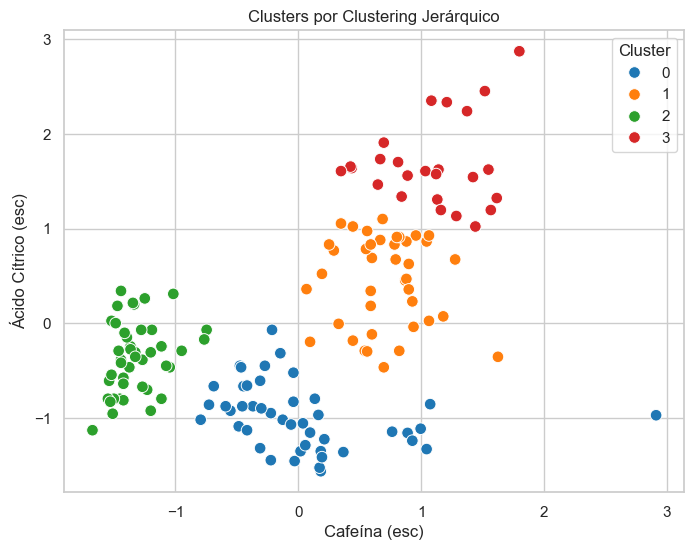

In [34]:
#grafico
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_scaled_df,
                x="Cafeína (esc)", y="Ácido Cítrico (esc)",
                hue="Cluster_Jerarquico", palette="tab10", s=70)
plt.title("Clusters por Clustering Jerárquico")
plt.legend(title="Cluster")
plt.show()

- Se identifican 4 grupos distintos, muy bien distribuidos en el espacio.
- Las fronteras entre clusters parecen lógicas y coherentes con la estructura de los datos.
- A diferencia de DBSCAN, no se detectan outliers, ya que todos los puntos se asignan a algún cluster

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [35]:
new_experiments = pd.read_csv("/Users/patri/Desktop/DS24/ONLINE_DS_THEBRIDGE_PGF/SPRINT_13/UNIDAD_2/practica_obligatoria/new_experiments.csv", sep="|")
new_experiments.head()


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583


In [37]:
# Selección de las mismas features usadas en el modelo original
X_new = new_experiments[["Cafeína", "Ácido Cítrico"]]

In [38]:
# Usar el mismo scaler que ya fue entrenado antes
X_new_scaled = scaler.transform(X_new)

In [40]:
## Combinamos datos antiguos + nuevos
X_total = np.vstack([X_scaled, X_new_scaled])

hc_total = AgglomerativeClustering(n_clusters=4, linkage='ward')
total_labels = hc_total.fit_predict(X_total)

# Separar las etiquetas de los nuevos
new_labels = total_labels[-len(X_new):]

In [41]:
#resultados
new_experiments["Cluster_Jerarquico"] = new_labels
new_experiments.head()


,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Cluster_Jerarquico
0,1.481555,0.305159,1.366128,2.239039,0.731870,3
1,0.616869,0.890014,0.583034,0.312420,-0.665332,1
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,0
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,0
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,2


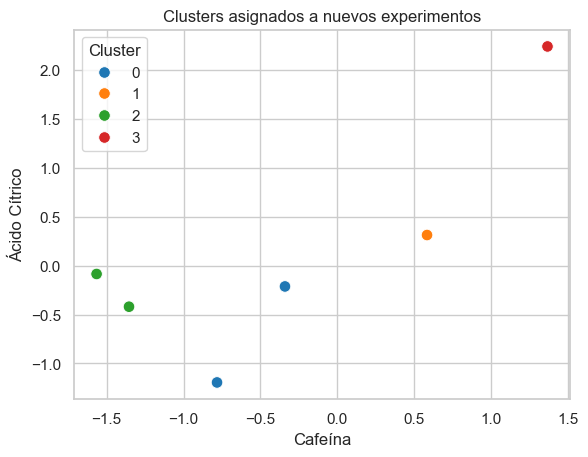

In [43]:
#grafico con los nuevos experimentos
sns.scatterplot(data=new_experiments, x="Cafeína", y="Ácido Cítrico",
                hue="Cluster_Jerarquico", palette="tab10", s=70)
plt.title("Clusters asignados a nuevos experimentos")
plt.legend(title="Cluster")
plt.show()

Hemos segmentado los nuevos experimentos usando el modelo jerárquico previamente entrenado, aplicando el mismo tratamiento de datos. Cada nueva mezcla ha sido asignada a uno de los 4 grupos detectados, lo que permitirá a los químicos decidir qué tipos de combinaciones explorar más a fondo.

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.